In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dask.array as da
from distributed import Client
from fish.image.zds import ZDS
from os import makedirs
from os.path import exists
from functools import partial
from scipy.ndimage.filters import median_filter
from fish.util.distributed import get_jobqueue_cluster
from dask.array import coarsen
from skimage.io import imsave
import time
from scipy.interpolate import interp1d
from glob import glob
from scipy.io import loadmat

In [43]:
base_dirs = ('/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_13_hucgcamp_5dpf_wholebrainstack_plane14_8339_20171015_201341/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_22_hucgcamp_5dpf_wholebrainstack_plane15_8333_20171015_225304/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_5_hucgcamp_5dpf_wholebrainstack_plane16_8327_20171015_175426/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_23_hucgcamp_5dpf_wholebrainstack_plane17_8321_20171015_230639/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_12_hucgcamp_5dpf_wholebrainstack_plane18_8315_20171015_195458/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_27_hucgcamp_5dpf_wholebrainstack_plane19_8309_20171016_001259/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_6_hucgcamp_5dpf_wholebrainstack_plane20_8303_20171015_181024/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_16_hucgcamp_5dpf_wholebrainstack_plane21_8297_20171015_211017/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_24_hucgcamp_5dpf_wholebrainstack_plane22_8291_20171015_232220/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_7_hucgcamp_5dpf_wholebrainstack_plane24_8285_20171015_182934/')


In [44]:
base_dir = base_dirs[-1]
print(base_dir)
single_plane = True
dset = ZDS(base_dir + 'raw/', single_plane=single_plane)
data = dset.data
result = None
print(data.shape)

/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_7_hucgcamp_5dpf_wholebrainstack_plane24_8285_20171015_182934/


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


(71000, 1, 1116, 2048)


In [45]:
exp_name = base_dir.split('/')[-2]
reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
ds_xy = 2

out_fname = f'{reg_dir}{exp_name}_dff_trave_ds{ds_xy}.tif'
window_fname = f'{reg_dir}{exp_name}_ave_window.npy'

if not exists(reg_dir):
    makedirs(reg_dir)
reg_path = reg_dir + 'regparams_affine.npy'
anat_ref_fname = reg_dir + 'anat_ref.tif'
fs_im = dset.metadata['volume_rate']

if single_plane:
    fs_im *= dset.metadata['dimensions'][-1]

swimf = glob(base_dir + 'swims/*swim_onset_CL_frame.mat')[0]
tmp = loadmat(swimf)
triggers = tmp['swim_onset_CL_frame'].squeeze()
pre = .5
post = 1.5
window = np.arange(-int(fs_im * pre), int(post * fs_im))
trinds = triggers.reshape(-1,1) + window
trinds = trinds[trinds.max(1) < data.shape[0]]
try:
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    print('affines not found, registration needs to be done')
    shifts = None
    data_filt = data.astype('float32').map_blocks(lambda v: median_filter(v, (1,1,5,5)), dtype='float32')
    mp = data.shape[0] // 2
    anat_ref = data_filt[slice(mp-5,mp+5)].mean(0).compute(scheduler='threads').astype('float32')
    imsave(anat_ref_fname, anat_ref)

affines not found, registration needs to be done


In [46]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

In [9]:
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.111.12:34417 Dashboard: http://10.36.111.12:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


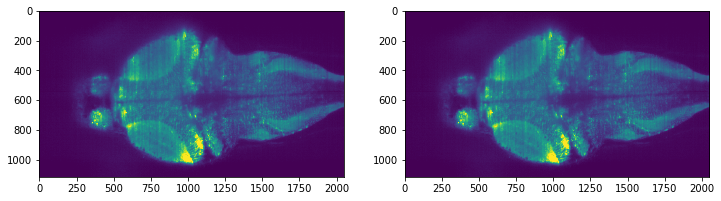

In [47]:
if shifts is None:
    reg_roi = (slice(None), slice(None), slice(None), slice(None))
    fig, axs = plt.subplots(ncols=2, figsize=(12,12))
    axs[0].imshow(anat_ref.max(0).squeeze(), clim=(100,200))
    axs[1].imshow(anat_ref[reg_roi[1:]].max(0).squeeze(), clim=(100,200))

In [48]:
%%time
if shifts is None:
    cluster.start_workers(300)
    ref_mx_bc = client.scatter(anat_ref[reg_roi[1:]].max(0), broadcast=True)
    data_filt = data[reg_roi].astype('float32').map_blocks(lambda v: median_filter(v, (1,1,5,5)), dtype='float32')
    if data_filt.shape[0] > 20000:
        ds_t = 4
        full_t = np.arange(data_filt.shape[0])
        affines_ds = da.map_blocks(reg, ref_mx_bc, data_filt[::ds_t].max(1), dtype='float32', chunks=(1,2,2)).compute()
        interper = interp1d(full_t[::ds_t], affines_ds, axis=0, bounds_error=False)
        affines = interper(full_t)        
    else:
        affines = da.map_blocks(reg, ref_mx_bc, data_filt.max(1), dtype='float32', chunks=(1,2,2)).compute()    
    np.save(reg_path, affines)
    shifts = -affines[:,:-1,-1]
    cluster.stop_all_jobs()

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 7min 8s, sys: 1min 7s, total: 8min 15s
Wall time: 15min 13s


Text(0, 0.5, 'Translation (um)')

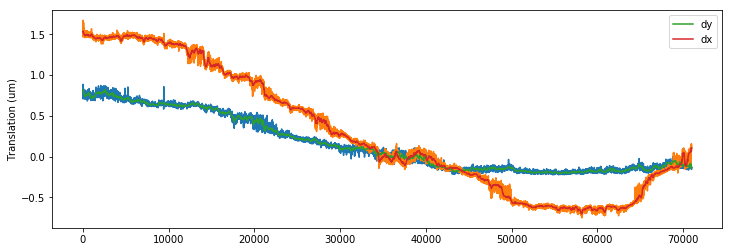

In [49]:
fig, axs = plt.subplots(figsize=(12,4))
um_per_pix = .40625
axs.plot(shifts * um_per_pix)
shifts_filt = median_filter(shifts, size=(150,1))
axs.plot(shifts_filt * um_per_pix)
axs.legend(axs.lines[2:], ['dy','dx'])
axs.set_ylabel('Translation (um)')

In [50]:
%%time
cluster.start_workers(10)
time.sleep(10)
shifts_filt_bc = client.scatter(shifts_filt)
medfilt = partial(median_filter, size=(1,1,3,3))
data_filt = data.astype('float32').map_blocks(medfilt, dtype='float32')
data_tx = data_filt.map_blocks(shift_yx, shifts_filt_bc, dtype='float32')

data_ds = coarsen(np.mean, data_tx, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 'auto', 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 6.41 s, sys: 2.21 s, total: 8.62 s
Wall time: 18.3 s


In [51]:
triggered = data_dff[trinds.ravel()].reshape((*trinds.shape, *data_dff.shape[1:]))

In [ ]:
%%time
cluster.start_workers(400)
result = triggered.mean(0).compute().squeeze()
time.sleep(10)
cluster.stop_all_jobs()

In [53]:
imsave(out_fname, result)
np.save(window_fname, window)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /groups/ahrens/ahrenslab/davis/tmp/20171015_2_7_hucgcamp_5dpf_wholebrainstack_plane24_8285_20171015_182934/20171015_2_7_hucgcamp_5dpf_wholebrainstack_plane24_8285_20171015_182934_dff_trave_ds2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [54]:
import flika as flk
flk.start_flika()
from flika.window import Window as flw

Starting flika
flika menubar already initialized.
Starting flika inside IPython


In [55]:
flw(result)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]
